In [2]:
import os
import torch
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from process import get_data_osmFish, process_data
from train import train
warnings.filterwarnings("ignore")

In [3]:
dataset = ['slice_1']
num_classes_list = [31]
start_k_neighbor_num = [8]
rad_distance_num = [500 for _ in range(len(dataset))]
alpha_lists = [[0.1] for _ in range(len(dataset))]
beta_lists = [[1.0] for _ in range(len(dataset))]
mid_k_neighbor_lists = [[4] for i in range(len(dataset))]
mid_feature_dims = []

# start_k_neighbor_num = [1]
# rad_distance_num = [500 for _ in range(len(dataset))]
# alpha_lists = [[0.1] for _ in range(len(dataset))]
# beta_lists = [[1.0] for _ in range(len(dataset))]
# mid_k_neighbor_lists = [[8] for i in range(len(dataset))]
# mid_feature_dims = []

In [4]:
adata_list_post = []
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
data_name = 'osmFish'
method = 'GraphSTAR'
hidden_dim = 30   # 聚类的维度
lr = 0.001
reg = 1e-5
epochs = 1000
mode ='KNN'
save_adata_root = '../res/{}/{}/data'.format(method, data_name)
# 细胞识别还是组织域识别
is_cell_identify = True
metric_list = {"ARI": [], "AMI": [], "NMI": []}
print("当前训练的数据集: {}".format(data_name))
for index, section_id in enumerate(dataset):
    print("切片:", section_id, " 聚类数量:", num_classes_list[index])
    adata = get_data_osmFish()
    adata = process_data(adata, data_name)
    if is_cell_identify:
        adata.obs['Ground Truth'] = adata.obs['ClusterName']
    else: adata.obs['Ground Truth'] = adata.obs['Region']
    print("adata = ", adata)
    adata = train(adata, 
                  data_name=data_name, 
                  num_class=num_classes_list[index], 
                  mode=mode,
                  start_k_neighbor=start_k_neighbor_num[index], 
                  rad_distance=rad_distance_num[index], 
                  hidden_dim=hidden_dim,
                  mid_k_neighbor_list=mid_k_neighbor_lists[index],
                  alpha_list=alpha_lists[index],
                  beta_list=beta_lists[index], 
                  mid_feature_dims=mid_feature_dims,
                  lr=lr,
                  reg=reg,
                  epochs=epochs,
                  file_name=section_id,
                  device=device)
    adata_list_post.append(adata)
    metric = adata.uns['metric']
    metric_list['ARI'].append(metric['ARI'])
    metric_list["AMI"].append(metric['AMI'])
    metric_list["NMI"].append(metric['NMI'])
    print('slice = %s last metric:, ARI = %.2f, AMI = %.2f, NMI = %.2f' % (section_id, metric["ARI"], metric["AMI"], metric["NMI"]))


当前训练的数据集: osmFish
切片: slice_1  聚类数量: 31
osmFish data has been preprocessed!
adata =  AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'Ground Truth'
    uns: 'ClusterName_colors'
    obsm: 'spatial'
空间位置的平均邻居数: tensor(9.3034)
空间位置的平均邻居数: tensor(9.3034)
in_features = 33, mid_feature1 = NULL, cluster_features = 30
begin training


100%|██████████| 1000/1000 [00:18<00:00, 55.43it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
slice = slice_1 last metric:, ARI = 0.48, AMI = 0.67, NMI = 0.68


In [5]:
# import scanpy as sc
# adata = adata_list_post[0].copy()
# print(adata)
# # 使用scanpy的leiden聚类
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

# # 先使用X特征进行leiden
# sc.pp.neighbors(adata, use_rep=None, random_state=SEED)
# sc.tl.leiden(adata, resolution=2.15)

# # 计算ARI，AMI，NMI
# sc.pl.umap(adata, color=['leiden', 'Ground Truth'], wspace=0.5)
# ARI = adjusted_rand_score(adata.obs['Ground Truth'], adata.obs['leiden'])
# AMI = adjusted_mutual_info_score(adata.obs['Ground Truth'], adata.obs['leiden'])
# NMI = normalized_mutual_info_score(adata.obs['Ground Truth'], adata.obs['leiden'])
# print("ARI = ", ARI)
# print("AMI = ", AMI)
# print("NMI = ", NMI)
# sc.pl.embedding(adata, basis='spatial', color='leiden')

In [9]:
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score
from utils import search_res
for index, section_id in enumerate(dataset):
    adata = adata_list_post[index]
    best_resolution = search_res(adata, n_clusters=num_classes_list[0], use_rep='embedding')
    print("best_resolution of leiden =", best_resolution)
    # sc.pp.neighbors(adata, use_rep='embedding', random_state=SEED, key_added='GraphSTAR')
    sc.tl.leiden(adata, resolution=best_resolution)
    adata_list_post[index] = adata

Searching resolution...
resolution=2.9899999999999984, cluster number=54, ARI=0.3841934622558674, AMI=0.6627610379529092 NMI=0.6799313896511218, Homogeneity=0.6199069873007979 completeness=0.7528260936481106 V_measure=0.6799313896511218 purity=0.5170489770613763
resolution=2.9799999999999986, cluster number=55, ARI=0.38306583924576454, AMI=0.6625801862370864 NMI=0.6800065413807136, Homogeneity=0.6194562756119519 completeness=0.7536764896008997 V_measure=0.6800065413807136 purity=0.5141558173176276
resolution=2.969999999999999, cluster number=55, ARI=0.3830098973010958, AMI=0.662589754564361 NMI=0.6800160622417605, Homogeneity=0.6194453487778543 completeness=0.7537160576508589 V_measure=0.6800160622417605 purity=0.5141558173176276
resolution=2.9599999999999986, cluster number=55, ARI=0.38593962541725363, AMI=0.6638208385036186 NMI=0.6812275095373077, Homogeneity=0.6201794585253441 completeness=0.7556064680328403 V_measure=0.6812275095373076 purity=0.5172556313287869
resolution=2.9499999

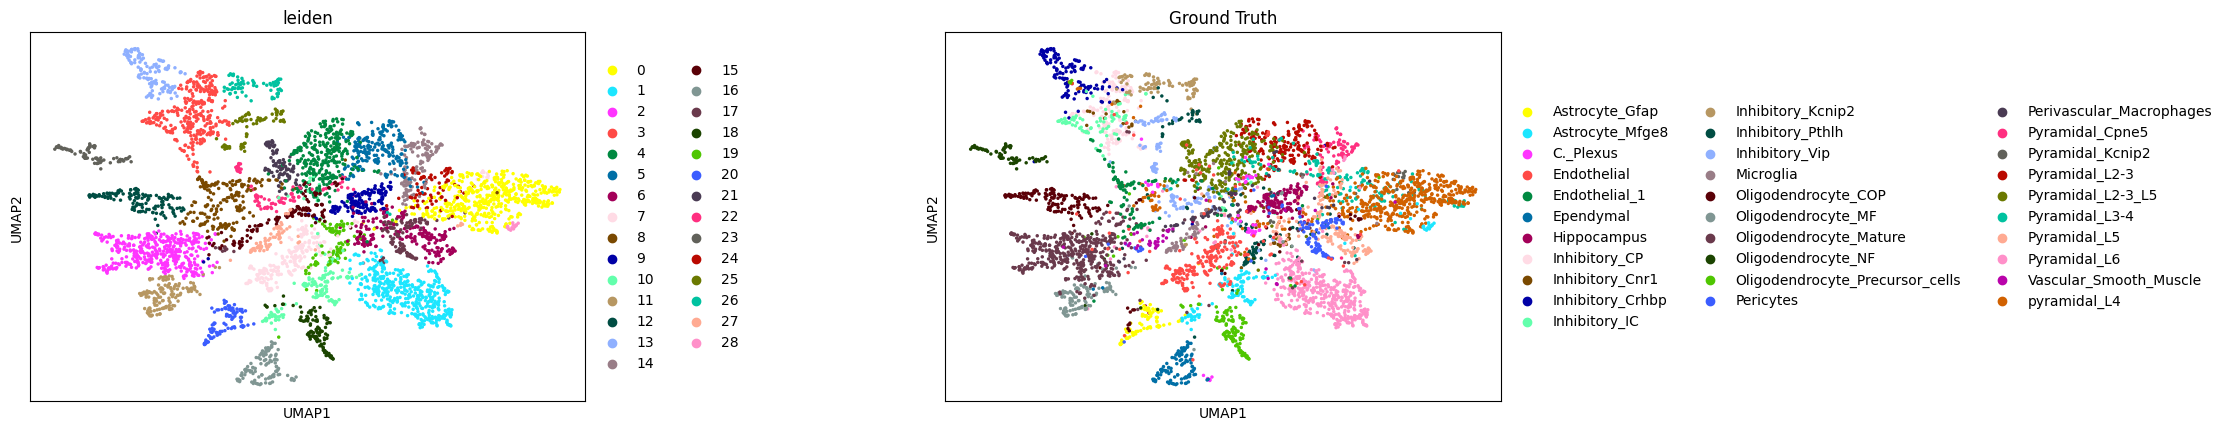

ARI = 0.6263865452135632,  AMI = 0.7087506203851662,  NMI = 0.7173214371096658


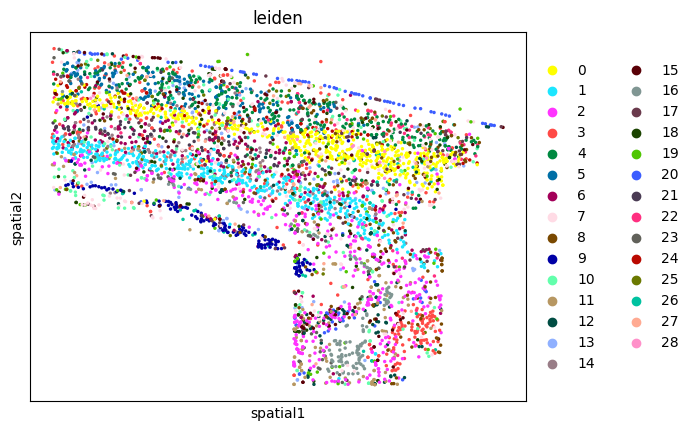

In [10]:
for index, section_id in enumerate(dataset):
    adata = adata_list_post[index]
    # 计算ARI，AMI，NMI
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=['leiden', 'Ground Truth'], wspace=0.5)
    ARI = adjusted_rand_score(adata.obs['Ground Truth'], adata.obs['leiden'])
    AMI = adjusted_mutual_info_score(adata.obs['Ground Truth'], adata.obs['leiden'])
    NMI = normalized_mutual_info_score(adata.obs['Ground Truth'], adata.obs['leiden'])
    print("ARI = {},  AMI = {},  NMI = {}".format(ARI, AMI, NMI))
    sc.pl.embedding(adata, basis='spatial', color='leiden')

In [8]:
for index, section_id in enumerate(dataset):
    # 保存到文件
    # 如果save_adata_root路径不存在
    if not os.path.exists(save_adata_root):
        os.makedirs(save_adata_root)
    adata = adata_list_post[index]
    print(adata)
    full_path_save_data = os.path.join(save_adata_root, 'slice_{} adata.h5ad'.format(section_id))
    adata.write_h5ad(full_path_save_data)

AnnData object with n_obs × n_vars = 4839 × 33
    obs: 'ClusterName', 'ClusterID', 'Region', 'Ground Truth', 'mclust', 'predict', 'leiden'
    uns: 'ClusterName_colors', 'adj', 'adj_norm', 'new_adj', 'metric', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'Ground Truth_colors'
    obsm: 'spatial', 'embedding', 'X_umap'
    obsp: 'distances', 'connectivities'
